In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

In [2]:
N_EPOCHS = 100    # number of epochs of training
BATCH_SIZE = 200   # size of the batches
LR = 2e-5         # adam: learning rate
B1 = 0.5          # adam: decay of first order momentum of gradient
B2 = 0.999        # adam: decay of first order momentum of gradient

N_CPU = 11         # number of cpu threads to use during batch generation
LATENT_DIM = 100  # dimensionality of the latent space
IMG_SIZE = 28     # size of each image dimension
CHANNELS = 1      # number of image channels
SAMPLE_INTERVAL = 400 # interval betwen image samples

In [3]:
img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)
cuda = True if torch.cuda.is_available() else False
print("CUDA:", cuda)

CUDA: False


In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(LATENT_DIM, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [14]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [15]:
# Configure data loader
# os.makedirs("../PyTorch/MNIST", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(IMG_SIZE), 
                transforms.ToTensor(), 
                transforms.Normalize([0.5], [0.5])
            ]
        ),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [16]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(B1, B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, B2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

gen_imgs:  torch.Size([200, 1, 28, 28])


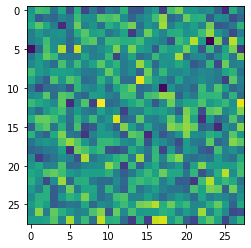

In [20]:
z = Variable(Tensor(np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))))

generator = Generator()
gen_imgs = generator(z)
plt.imshow(gen_imgs[0][0].detach().numpy())
print("gen_imgs: ", gen_imgs.size())

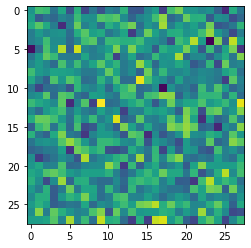

In [21]:
plt.imshow(torch.tanh(gen_imgs[0][0]).detach().numpy())


In [9]:
for epoch in range(N_EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], LATENT_DIM))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % SAMPLE_INTERVAL == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
    
    print(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, N_EPOCHS, d_loss.item(), g_loss.item())
        )

[Epoch 0/100] [D loss: 0.573077] [G loss: 0.558039]
[Epoch 1/100] [D loss: 0.539105] [G loss: 0.714831]
[Epoch 2/100] [D loss: 0.389402] [G loss: 0.970982]
[Epoch 3/100] [D loss: 0.341055] [G loss: 1.083028]
[Epoch 4/100] [D loss: 0.306307] [G loss: 1.185879]
[Epoch 5/100] [D loss: 0.312037] [G loss: 1.344943]
[Epoch 6/100] [D loss: 0.262382] [G loss: 1.262368]
[Epoch 7/100] [D loss: 0.236451] [G loss: 1.505051]
[Epoch 8/100] [D loss: 0.233210] [G loss: 1.607836]
[Epoch 9/100] [D loss: 0.189567] [G loss: 1.691050]
[Epoch 10/100] [D loss: 0.224868] [G loss: 1.705013]
[Epoch 11/100] [D loss: 0.264818] [G loss: 1.637902]


KeyboardInterrupt: 